<a href="https://colab.research.google.com/github/michelli-ofig/DataScience_Em_Producao/blob/main/m06_v01_store_sales_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 0.0. Imports

In [119]:
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.7.10


In [120]:
import matplotlib.pyplot as plt
%matplotlib inline  

In [121]:
!pip install tabulate

In [122]:
!pip install inflection

In [123]:
!pip install boruta

In [124]:
import inflection
import math 
import seaborn as sns
import matplotlib.gridspec as gridSpec
import numpy as np
import datetime as dt
import pandas as pd
import timedelta
from tabulate              import tabulate
from datetime              import timedelta
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder 
from sklearn.ensemble      import RandomForestRegressor
from scipy                 import stats as ss
from matplotlib            import pyplot as plt
from matplotlib            import rcParams
from numpy                 import int64
from IPython.display       import Image
from datetime              import datetime
from datetime              import timedelta
from boruta                import BorutaPy

### 0.1. Helper Functions

In [125]:
def cramer_v (x,y):
    cm= pd.crosstab(x,y).values
    n=cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    return np.sqrt((chi2corr/n)/(min( kcorr-1, rcorr-1)))


### 0.2. Carregando os Dados

In [126]:
from google.colab import drive
drive.mount('/content/drive')

df_sales_raw = pd.read_csv('/content/drive/MyDrive/repos/DataScience_Em_Producao/data/train.csv')
df_store_raw = pd.read_csv('/content/drive/MyDrive/repos/DataScience_Em_Producao/data/store.csv')





Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [127]:
from google.colab import drive
drive.mount('/content/drive')

df_sales_raw = pd.read_csv('/content/drive/MyDrive/repos/DataScience_Em_Producao/data/train.csv')
df_store_raw = pd.read_csv('/content/drive/MyDrive/repos/DataScience_Em_Producao/data/store.csv')





Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [128]:
df_store_raw.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [129]:
df_sales_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [130]:
df_raw= pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')



In [131]:
df_sales_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [132]:
df_raw=pd.merge(df_sales_raw, df_store_raw, how='left', on= 'Store' )

In [133]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
15746,137,5,2015-07-17,6832,936,1,1,0,0,a,a,1730.0,7.0,2015.0,1,40.0,2014.0,"Jan,Apr,Jul,Oct"


In [134]:
print(df_raw.shape)

(1017209, 18)


# 1 - Descrição dos dados

## 1.0 - Rename Columns

In [135]:
df1=df_raw.copy()

In [136]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [137]:
cols_old= ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'] 

In [138]:
snakecase = lambda x: inflection.underscore(x)  #Função para transformar os dados em snakecase
cols_new = list(map(snakecase, cols_old))

In [139]:
df1.columns = cols_new

In [140]:

df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 Data Dimensions

In [141]:
print('Number of Rows: {}' .format(df1.shape[0]))
print('Number of Cols: {}' .format(df1.shape[1]))

Number of Rows: 1017209
Number of Cols: 18


## 1.3 Data Type

In [142]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object


## 1.4 Check NA

In [143]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

# 1.5 Fillout NA 

In [144]:
#competition_distance              2642
#competition_open_since_month    323348
#competition_open_since_year     323348
#promo2_since_week               508031
#promo2_since_year               508031
#promo_interval                  508031

In [145]:
#competition_distance 
df1['competition_distance'].max()

75860.0

In [146]:
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x)else x)

In [147]:
print(df1[df1['competition_distance']==200000.0].shape)

(2642, 18)


In [148]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance                 0
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

In [149]:
df1['date']= pd.to_datetime(df1['date'])

In [150]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

In [151]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance                 0
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

In [152]:
df1['competition_open_since_year']=df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x ['competition_open_since_year'], axis=1 )
df1['competition_open_since_month']=df1.apply(lambda x: x['date'].month if math.isnan(x ['competition_open_since_month']) else x['competition_open_since_month'], axis=1)   

In [153]:
#promo2_since_week
df1['promo2_since_week']=df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x ['promo2_since_week'],axis=1 )

#promo2_since_year 
df1['promo2_since_year']=df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x ['promo2_since_year'], axis=1 )

#Dicionario criado para fazer o mapeamento para a coluna month_map
month_map = {1:'Jan',2:'Fev', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}

#Preenchendo os NA com 0
df1['promo_interval'].fillna(0, inplace=True)

#Criando a coluna month_map buscando a partir no mês da coluna data 
df1['month_map'] = df1['date'].dt.month.map(month_map)

#Criando a coluna in_promo: Se o mês da coluna month map estiver contido na coluna promo interval retorna 1(esta participando da promo), 
#se retornar 0 signigica que não esta participando da promoção.

df1['in promo']= df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 
else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)
                                                            










In [154]:
df1.sample(50).T

,505742,69836,653175,267179,829871,977734,800904,285013,498119,785056,256760,308767,277407,925580,319715,991484,779863,78629,837998,324010,547053,668865,1015996,941736,543335,49183,864854,257861,762846,284587,650679,108581,246775,337937,51054,776840,747831,383926,58078,285321,400538,217818,867500,249120,274086,904279,903479,660462,700917,211399
store,318,707,571,1050,1097,665,5,15,500,882,892,466,983,916,148,1035,149,580,304,812,374,651,1017,347,1,124,400,1086,972,624,305,427,133,693,880,471,452,899,99,383,640,394,816,704,368,800,1115,53,368,665
day_of_week,5,6,6,6,2,2,6,7,5,7,3,3,2,7,5,4,4,5,1,1,3,6,3,6,6,3,5,2,6,1,1,6,6,7,2,7,5,7,2,7,3,6,3,4,5,5,6,6,5,5
date,2014-04-04 00:00:00,2015-05-30 00:00:00,2013-11-23 00:00:00,2014-11-29 00:00:00,2013-06-18 00:00:00,2013-02-05 00:00:00,2013-07-13 00:00:00,2014-11-09 00:00:00,2014-04-11 00:00:00,2013-07-28 00:00:00,2014-12-10 00:00:00,2014-10-15 00:00:00,2014-11-18 00:00:00,2013-03-24 00:00:00,2014-10-03 00:00:00,2013-01-24 00:00:00,2013-08-01 00:00:00,2015-05-22 00:00:00,2013-06-10 00:00:00,2014-09-29 00:00:00,2014-02-26 00:00:00,2013-11-09 00:00:00,2013-01-02 00:00:00,2013-03-09 00:00:00,2014-03-01 00:00:00,2015-06-17 00:00:00,2013-05-17 00:00:00,2014-12-09 00:00:00,2013-08-17 00:00:00,2014-11-10 00:00:00,2013-11-25 00:00:00,2015-04-25 00:00:00,2014-12-20 00:00:00,2014-09-14 00:00:00,2015-06-16 00:00:00,2013-08-04 00:00:00,2013-08-30 00:00:00,2014-07-27 00:00:00,2015-06-09 00:00:00,2014-11-09 00:00:00,2014-07-09 00:00:00,2015-01-17 00:00:00,2013-05-15 00:00:00,2014-12-18 00:00:00,2014-11-21 00:00:00,2013-04-12 00:00:00,2013-04-13 00:00:00,2013-11-16 00:00:00,2013-10-11 00:00:00,2015-01-23 00:00:00
sales,8157,5399,9411,10334,10318,9971,2451,0,5057,0,7417,6597,6194,0,0,5730,6854,9779,5994,8932,5951,7802,7046,4579,5307,5741,8267,6343,1441,9624,5773,6023,6000,0,9742,0,6921,0,5451,0,8335,8355,6771,15234,7873,6479,5007,3300,9227,7074
customers,722,532,681,679,3140,1429,265,0,385,0,737,710,930,0,0,689,552,1487,1055,982,780,1027,1131,399,655,615,1161,737,203,855,482,657,609,0,956,0,612,0,474,0,678,726,937,1431,655,613,410,392,675,1193
open,1,1,1,1,1,1,1,0,1,0,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0,1,0,1,0,1,1,1,1,1,1,1,1,1,1
promo,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,1,1,1,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,1,0,1,0,0,1,0
state_holiday,0,0,0,0,0,0,0,0,0,0,0,0,0,0,a,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
school_holiday,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
store_type,d,a,d,d,b,a,a,d,d,a,a,a,a,a,a,a,d,a,a,d,a,a,c,d,c,a,a,a,a,a,c,a,a,d,a,d,a,d,c,a,d,d,c,d,d,d,d,a,d,a


In [155]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
in promo                        0
dtype: int64

In [156]:
print(df1['in promo'].unique() )

[0 1]


In [157]:
print(df1[df1['in promo']==1].shape)

(157902, 20)


In [158]:
print(df1.shape)

(1017209, 20)


## 1.6 Change dtypes

In [159]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
in promo                                 int64
dtype: object

In [160]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int64)


In [161]:
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int64)


In [162]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
in promo                                 int64
dtype: object

In [163]:
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int64)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int64)


In [164]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
in promo                                 int64
dtype: object

## 1.7 Descritive Statistical

In [165]:
num_attributes = df1.select_dtypes(include = ['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64','datetime64[ns]'])

In [166]:
cat_attributes.sample(2)

,state_holiday,store_type,assortment,promo_interval,month_map
111357,0,d,c,"Jan,Apr,Jul,Oct",Apr
639151,0,a,a,"Feb,May,Aug,Nov",Dec


### 1.7.1 Numerical Attributes

In [167]:
#Central Tendence - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew()  )).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis() )).T

#concatenate

m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6] ).T.reset_index()
m.columns = ['atributes','min', 'max', 'range', 'mean', 'median', 'std', 'skew','kurtosis']
m




,atributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


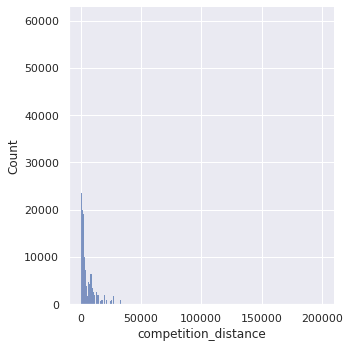

In [168]:
sns.set(rc={'figure.figsize':(30,21.27)})
sns.displot(df1['competition_distance'])


### 1.7.2 Categorical Attributes

In [169]:
cat_attributes.apply(lambda x: x.unique().shape[0]) #Imprime os tipos de cada variável

state_holiday      5
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

In [170]:
df1.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,in promo
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9,2008,0,31,2015,0,Jul,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9,2009,0,31,2015,0,Jul,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4,2015,0,31,2015,0,Jul,0


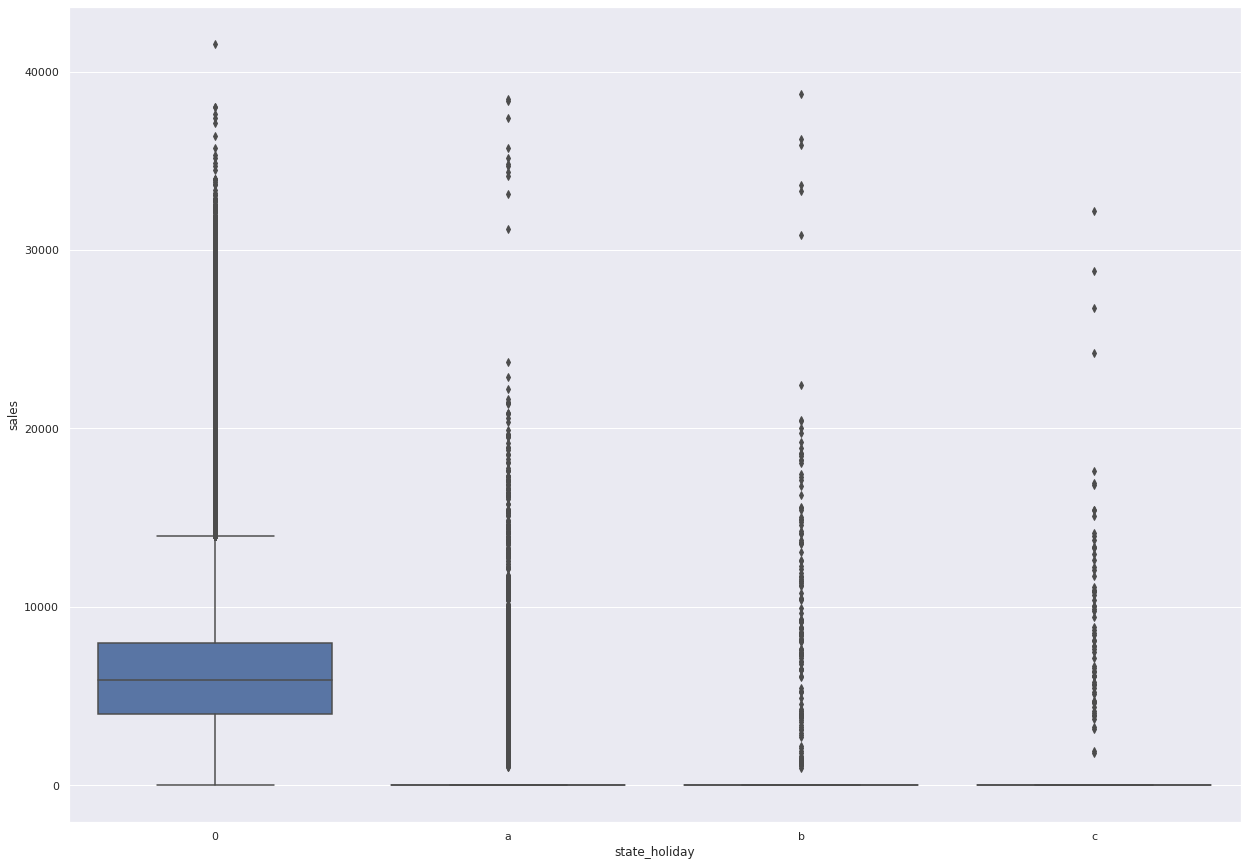

In [171]:
sns.set(rc={'figure.figsize':(21,15)})
aux1 = df1[df1['state_holiday'] != 0 & (df1['sales'] > 0)]
sns.boxplot ( x ='state_holiday', y= 'sales', data= aux1)

# 2.0 PASSO 02: FEATURE ENGINEERING

## 2.1 Mapa Mental de Hipóteses

In [172]:
df2 = df1.copy()

In [173]:
Image('img/MindMapHipothesis.png')


## Criação  das Hipóteses

## 2.1.1 Hipóteses Lojas

**1.** Lojas com maior quadro de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com competidores mais próximos deveriam vender menos.

**5.** Lojas com competidores a mais tempos deveriam vender mais .

**6.** Lojas com maior sortimento deveriam vender mais.

## 2.1.2 Hipóteses Produtos


 **1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas que expõe mais os produtos nas vitrines deveriam vender mais.

**3.** Lojas que tem preços menores nos produtos deveriam vender mais.

**4.** Lojas como promoções mais agressivas (descontos maiores), deveriam vender mais.

**5.** Lojas como promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoção deveriam vender mais 



## 2.1.3. Hipótese Tempo    


**1.** Lojas abertas durante o feriado do Natal deveriam vender mais.

**2.** Lojas  deveriam vender mais ao longo dos anos.

**3.** Lojas  deveriam vender mais no segundo semestre do ano.

**4.** Lojas  deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas  deveriam vender menos aos final de semana.

**6.** Lojas  deveriam vender menos durante os feriados escolares.

## 2.2 Lista final de Hipóteses

**1.** Lojas com competidores mais próximos deveriam vender menos.

**2.** Lojas com maior sortimento deveriam vender mais.

**3.** Lojas com competidores a mais tempos deveriam vender mais.

**4.** Lojas como promoções mais agressivas (descontos maiores), deveriam vender mais.

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoção deveriam vender mais. 

**7.** Lojas abertas durante o feriado do Natal deveriam vender mais.

**8.** Lojas  deveriam vender mais ao longo dos anos.

**9.** Lojas  deveriam vender mais no segundo semestre do ano.

**10.** Lojas  deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas  deveriam vender menos aos finais de semana.

**12.** Lojas  deveriam vender menos durante os feriados escolares.





## 2.3 Feature Enginnering

In [174]:
#year 
df2['year'] = df2['date'].dt.year

#month
df2['month'] = df2['date'].dt.month

#day
df2['day'] = df2['date'].dt.day

#week_of_year
df2['week_of_year'] = df2['date'].dt.isocalendar().week
#df2['week_of_year'] = df2['date'].dt.weekofyear

# year_week
df2['year_week'] = df2['date'].dt.strftime('%Y - %W')

# competition_since
df2['competition_since']= df2.apply( lambda x: dt.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
df2['competition_time_month']= ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: dt.datetime.strptime(x + '-1','%Y-%W-%w') - dt.timedelta(days=7))
df2['promo_time_week'] =((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

#assortment
df2['assortment']= df2['assortment'].apply(lambda x: 'basic' if x=='a' else 'extra' if x=='b' else 'extended')

#state_holiday
df2['state_holiday']=df2['state_holiday'].apply(lambda x: 'public_holiday' if x=='a' else 'easter_holiday' if x=='b' else 'christmas' if x=='c' else 'regular_day')





In [175]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0 Filtragem de Imóveis 

In [176]:
df3 = df2.copy()

In [177]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,in promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015 - 30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015 - 30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015 - 30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015 - 30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015 - 30,2015-04-01,4,2015-07-27,0


In [178]:
df3 = df3[(df3['open']!=0)& (df3['sales']!=0)]

## 3.2. Seleção das Colunas

In [179]:
cols_drop = ['customers','open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

# 4.0 - ANÁLISE EXPLORATÓRIA DOS DADOS

In [180]:
df4 = df3.copy()

In [181]:
df4.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,in promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015 - 30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015 - 30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015 - 30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015 - 30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015 - 30,2015-04-01,4,2015-07-27,0


## 4.1 Análise Univariada

### 4.1.2 Response Variable

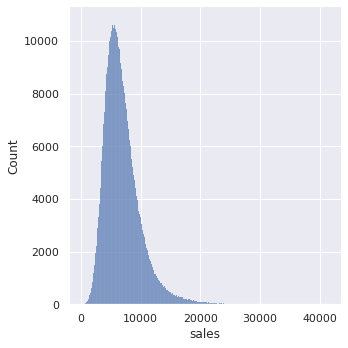

In [182]:
plt.rcParams['figure.figsize'] = (21,30)
sns.displot(df4['sales']);

### 4.1.2 Numerical Variable

In [183]:
cat_attributes.head()

#state_holiday	
#store_type	
#assortment	


,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


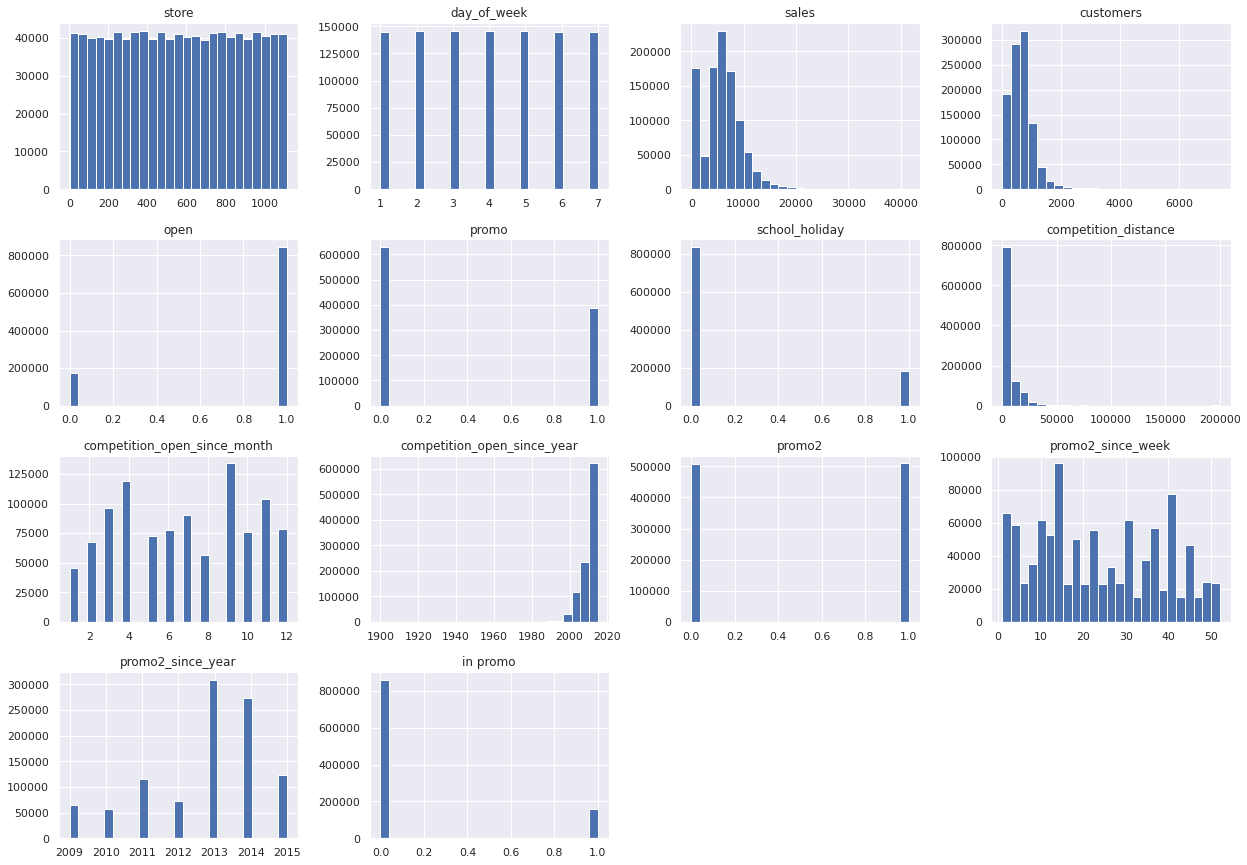

In [184]:
sns.set(rc={'figure.figsize':(21,15)})
num_attributes.hist(bins =25);

### 4.1.3 Categorical Variable

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


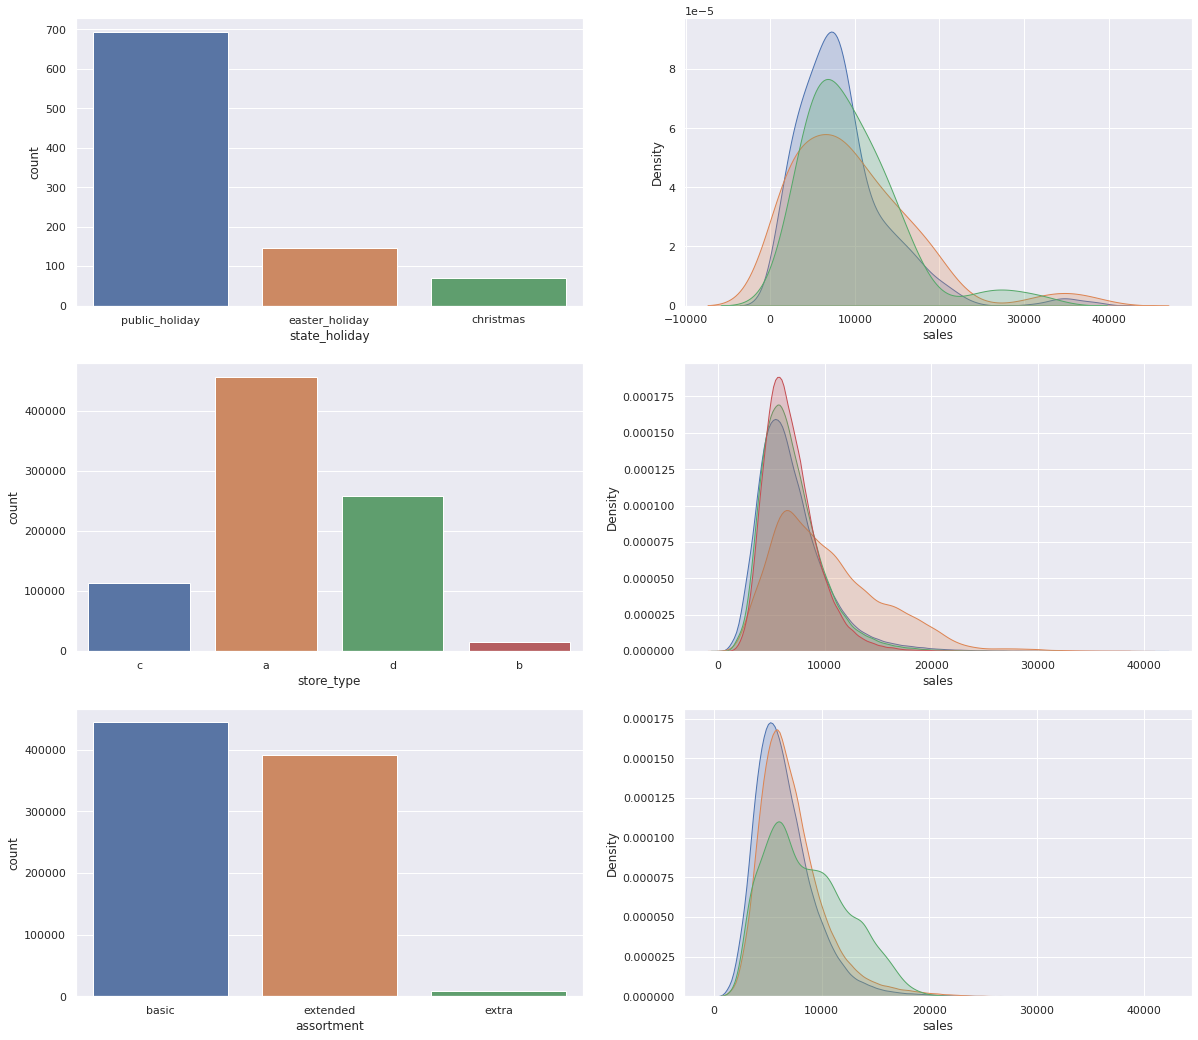

In [185]:
#state_holiday
plt.figure( figsize=(20, 18))
plt.subplot(3,2,1)

a = df4[df4['state_holiday']!= 'regular_day']
sns.countplot(a['state_holiday'])


plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'],label ='public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'],label ='easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'],label ='christmas', shade=True)

#store_type

plt.subplot(3,2,3)
sns.countplot(df4['store_type']);

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'],label ='a', shade=True);
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'],label ='b', shade=True);
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'],label ='c', shade=True);
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'],label ='d', shade=True);

#assortment

plt.subplot(3,2,5)
sns.countplot(df4['assortment']);

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'],label ='basic', shade=True);
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'],label ='extended', shade=True);
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'],label ='extra', shade=True);








## 4.2 Análise Bivariada

### H1. Lojas com maior sortimento deveriam vender mais.
***False*** Lojas com MAIOR SORTIMENTO vendem MENOS

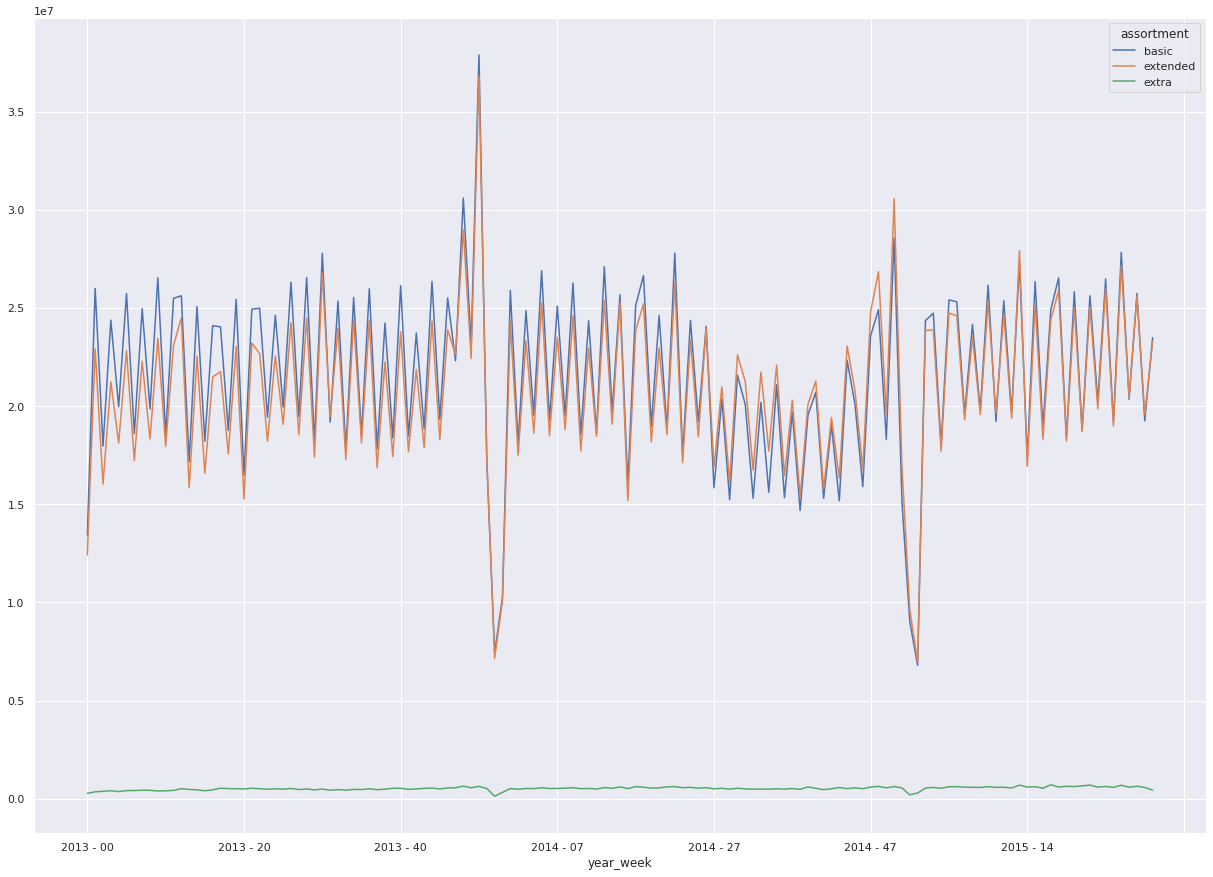

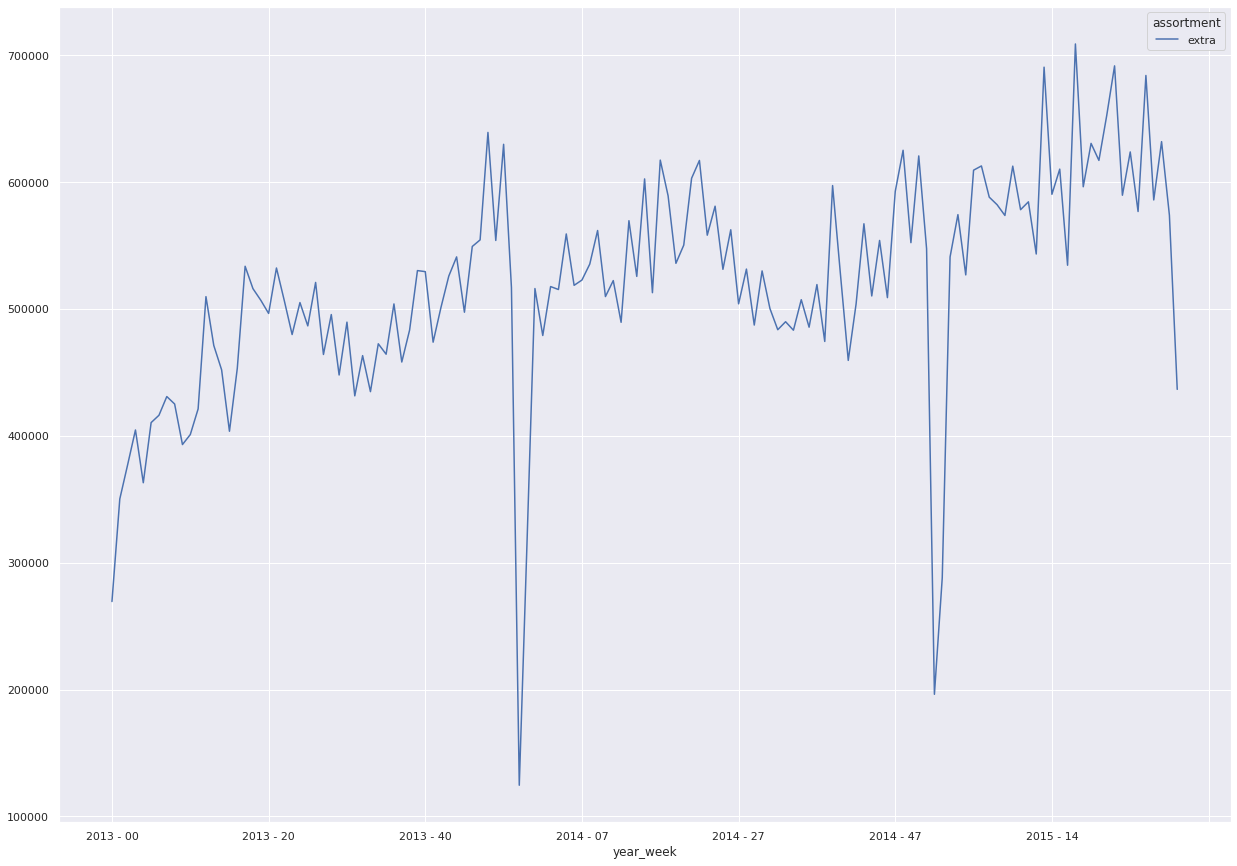

In [186]:
aux1= df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()

aux2 = df4[['year_week','assortment','sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot(index= 'year_week', columns='assortment', values='sales').plot();

aux3 = aux2[aux2['assortment']=='extra']
aux3.pivot(index= 'year_week', columns='assortment', values='sales').plot();

###  H2 - Lojas com competidores mais próximos deveriam vender menos.
**Falsa** Lojas com competidores mais PRÓXIMOS vendem MAIS






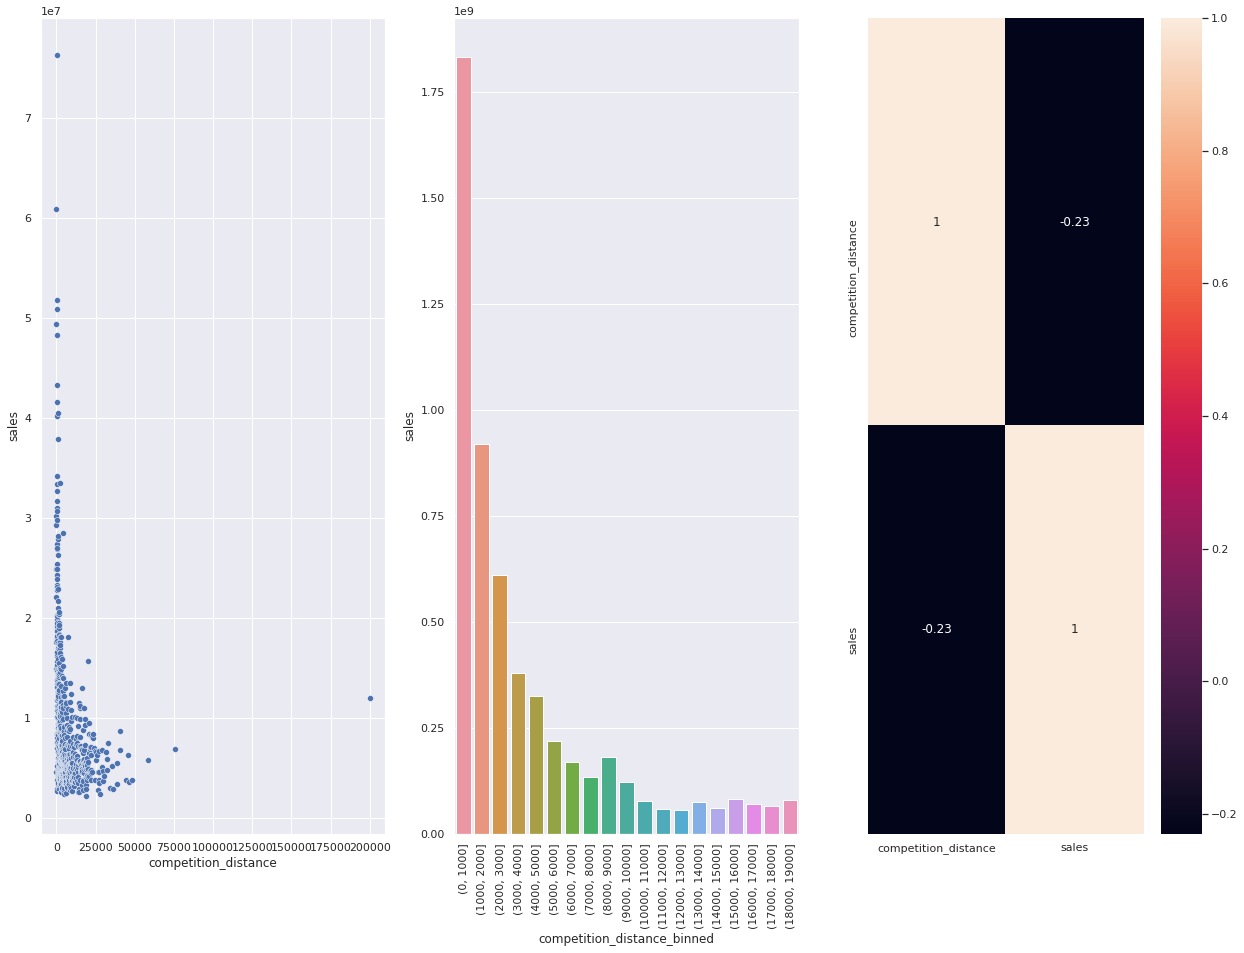

In [187]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
plt.subplot(1,3,1)
sns.scatterplot(x ='competition_distance', y='sales', data=aux1)

plt.subplot(1,3,2)
bins = list(np.arange(0,20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);
plt.xticks(rotation=90)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### H3. Lojas com competidores a mais tempo deveriam vender mais.
**Falsa** Loja com COMPETIDORES a MAIS TEMPO vende MENOS. 

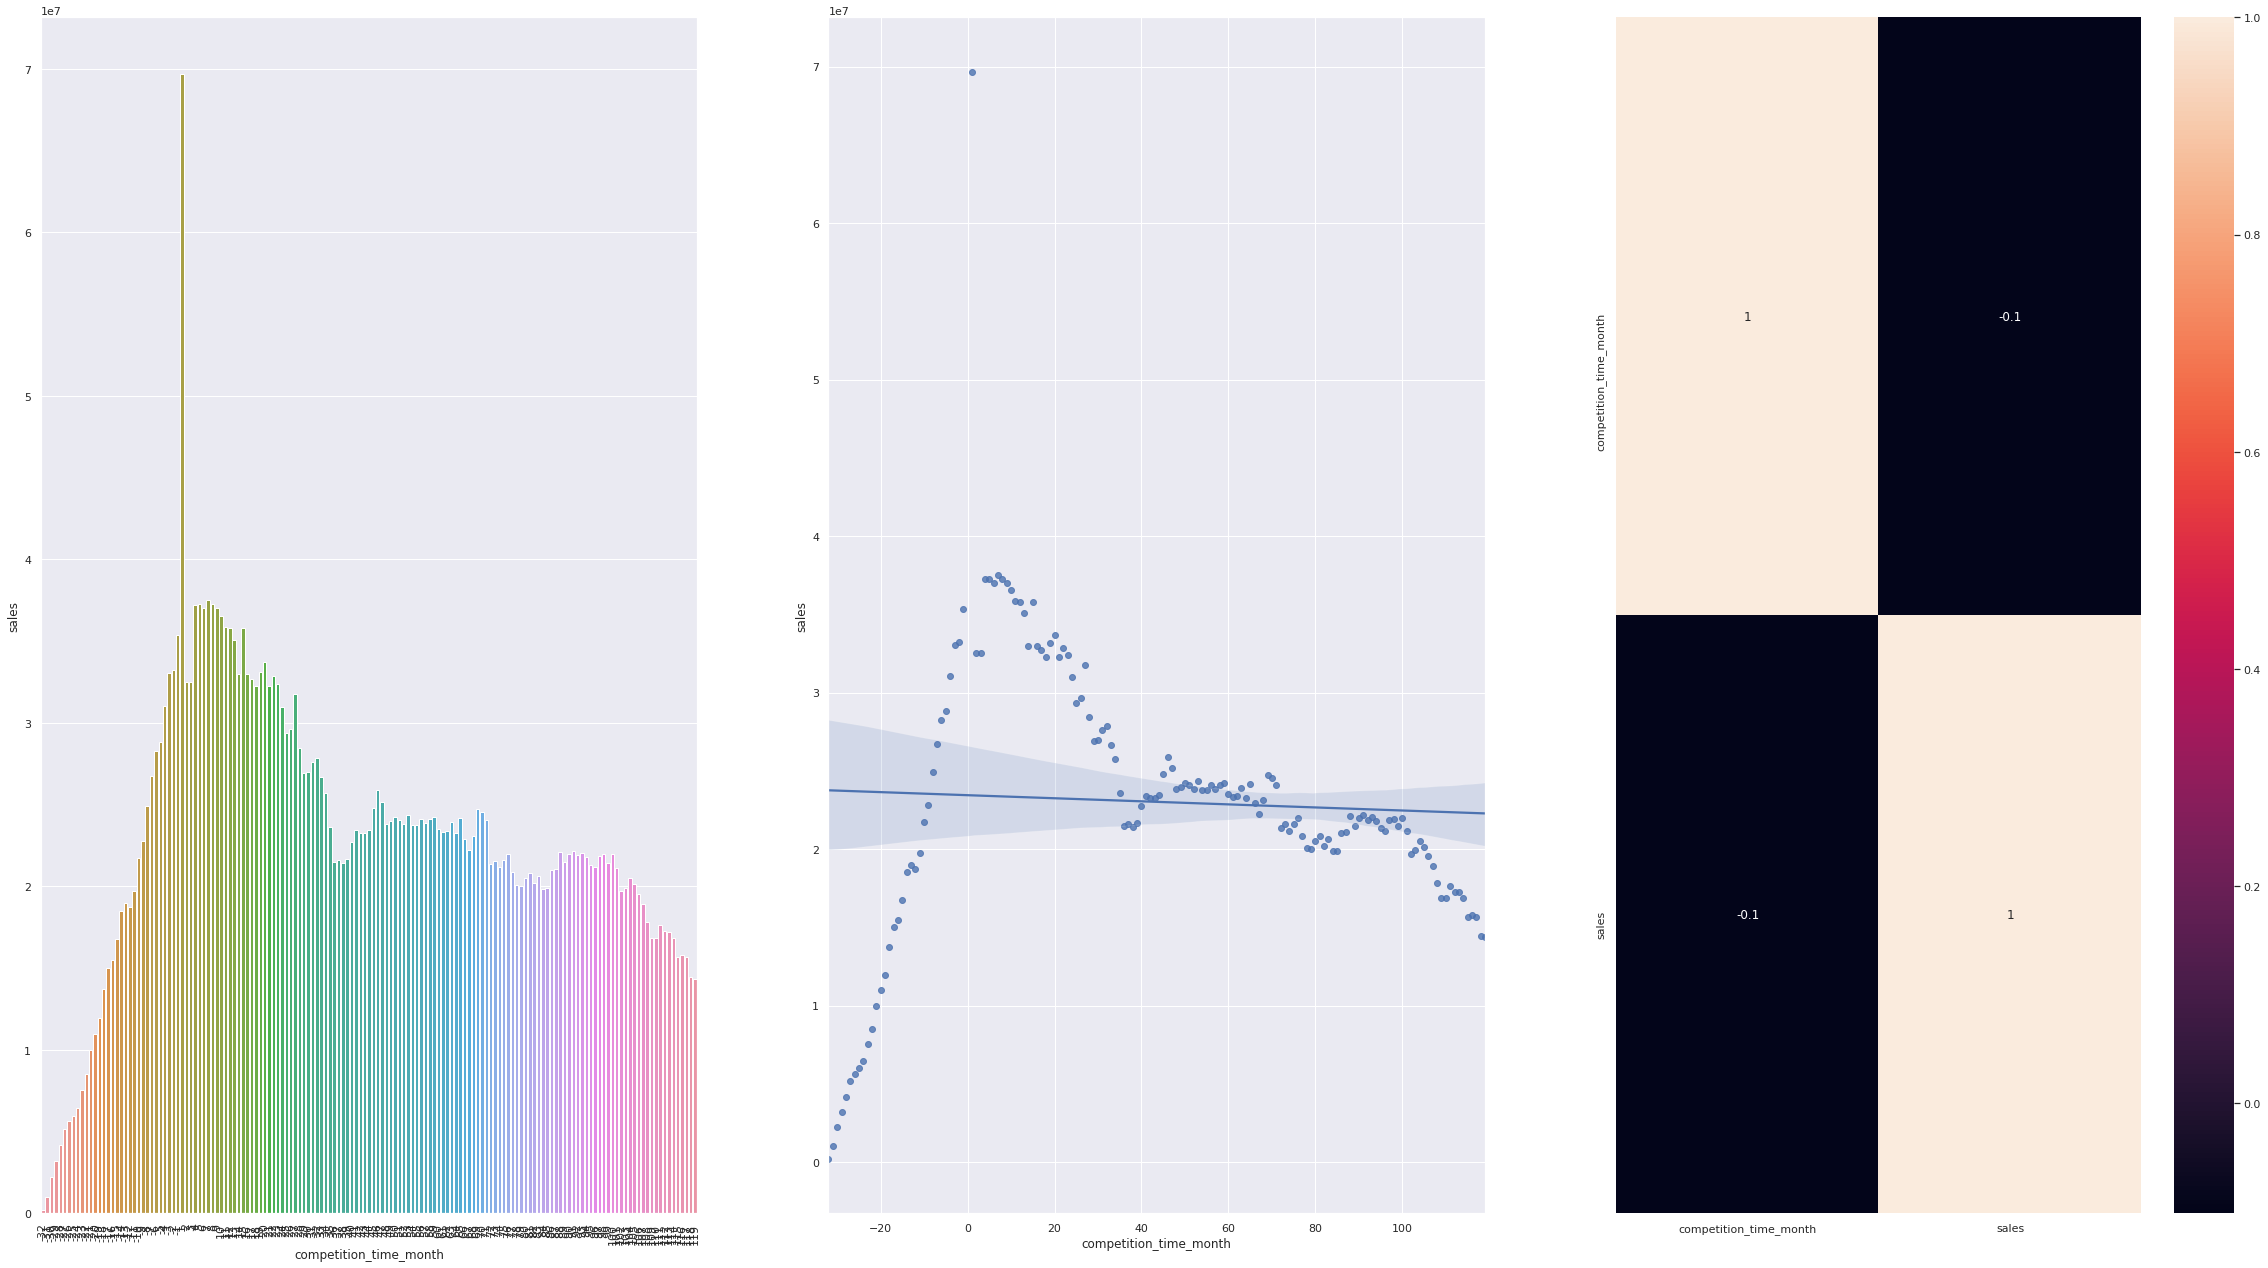

In [188]:
plt.figure( figsize=(40, 22))

plt.subplot(1,3,1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month']<120)& (aux1['competition_time_month'] !=0)]
sns.barplot(x='competition_time_month', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(1,3,2)
sns.regplot(x='competition_time_month', y='sales', data=aux2)

plt.subplot(1,3,3)
x=sns.heatmap(aux1.corr(method='pearson'), annot =True)




### **H4.**  Lojas como promoções ativas por mais tempo deveriam vender mais.
**Falsa** Lojas com promoçoes ativas por MAIS TEMPO vendem MENOS, depois de um certo período de promoção.

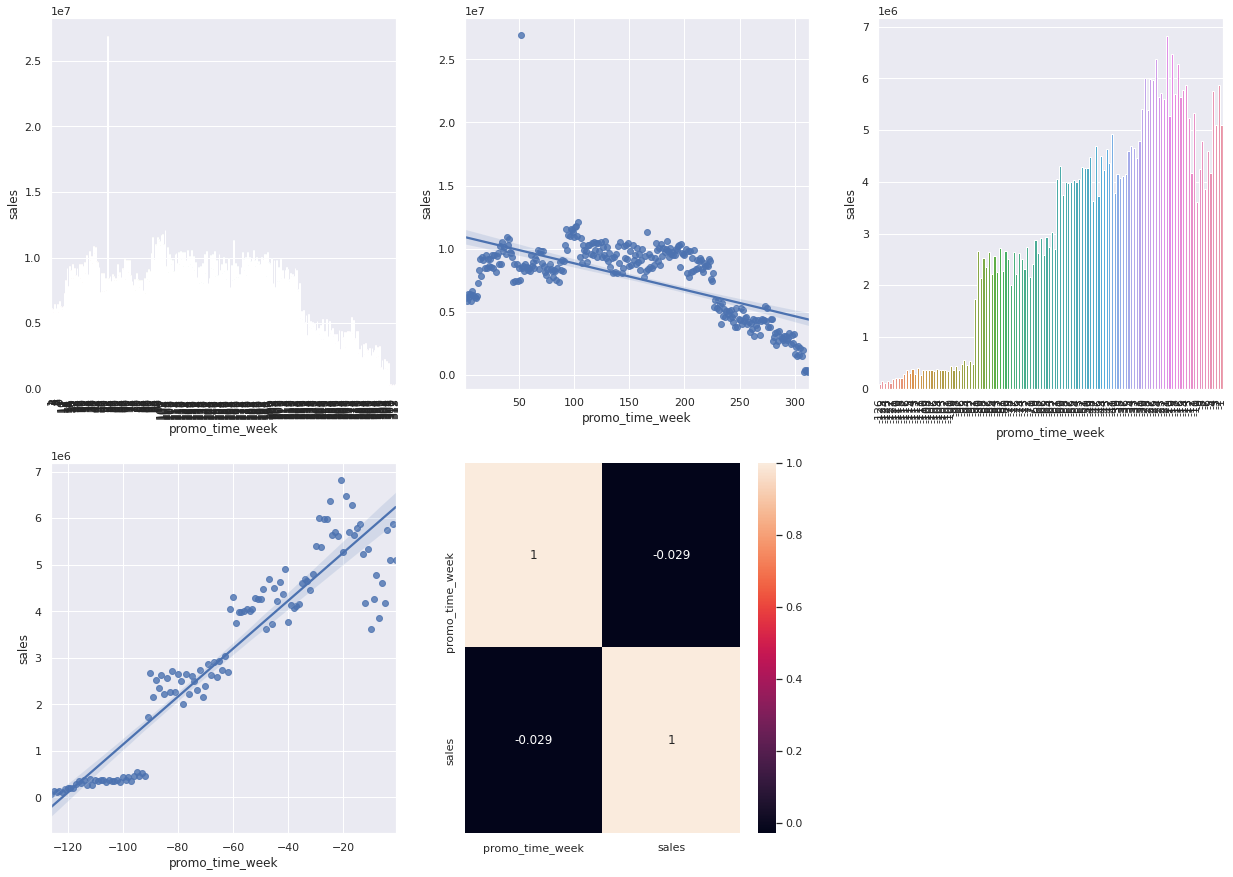

In [189]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

plt.subplot(2,3,1)
aux2 = aux1[aux1['promo_time_week'] > 0]  #promo extendido
sns.barplot(x='promo_time_week', y='sales', data=aux2);
plt.xticks(rotation =90);

plt.subplot(2,3,2)
sns.regplot(x='promo_time_week', y='sales', data=aux2);

plt.subplot(2,3,3)
aux3 = aux1[aux1['promo_time_week'] < 0]  #promo regular 
sns.barplot(x='promo_time_week', y='sales', data=aux3);
plt.xticks(rotation =90);

plt.subplot(2,3,4)
sns.regplot(x='promo_time_week', y='sales', data=aux3);

plt.subplot(2,3,5)
sns.heatmap(aux1.corr(method='pearson'), annot=True);


### <s>**H5.** Lojas com mais dias de promoção deveriam vender mais </s>


### **H6.** Lojas como promoções consecutivas deveriam vender mais.
**Falsa** Lojas como promoções consecutivas vendem menos.

In [190]:
df4[['promo','promo2', 'sales']].groupby(['promo','promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


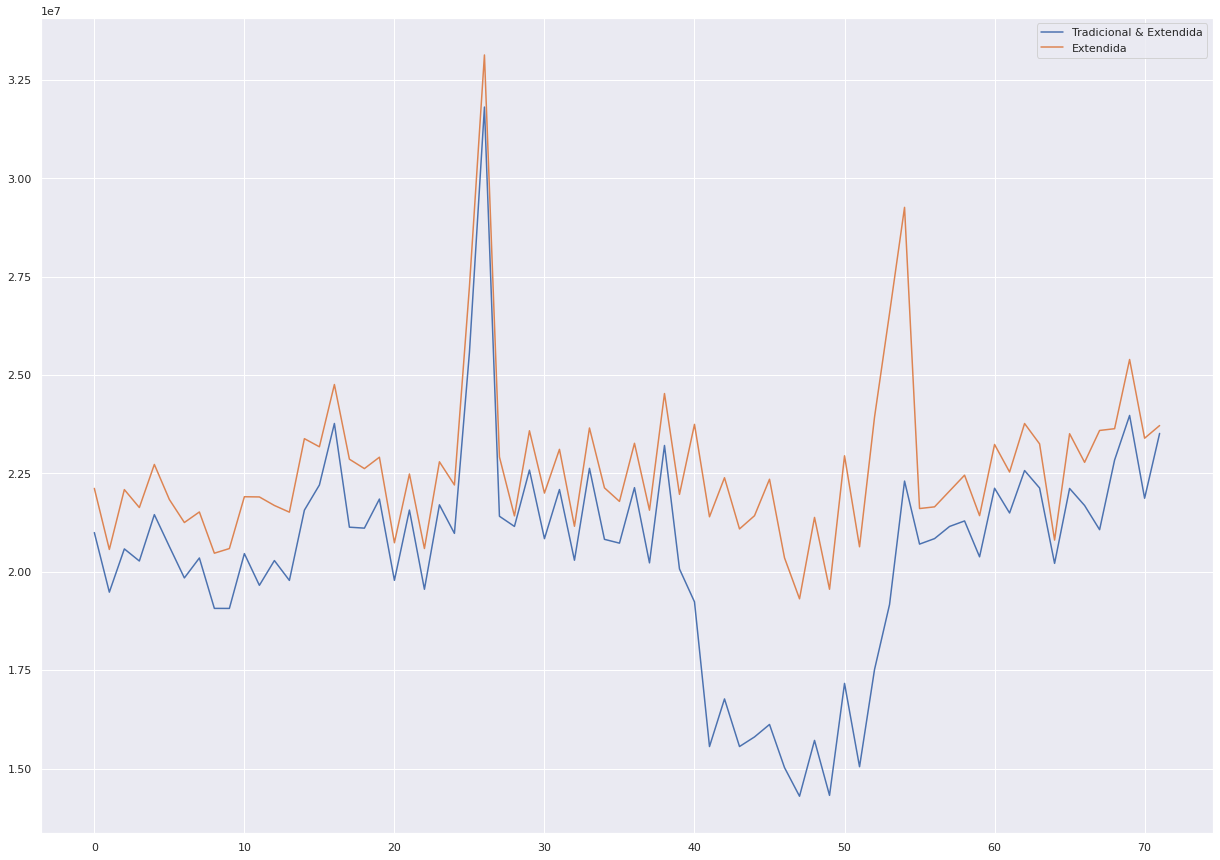

In [191]:
aux1 = df4[(df4['promo']==1) & (df4['promo2']==1)][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo']==1) & (df4['promo2']==0)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['Tradicional & Extendida','Extendida']);

### **H7.** Lojas abertas durante o feriado do Natal deveriam vender mais.
**Falsa** Lojas abertas durante o feriado do Natal vendem menos.

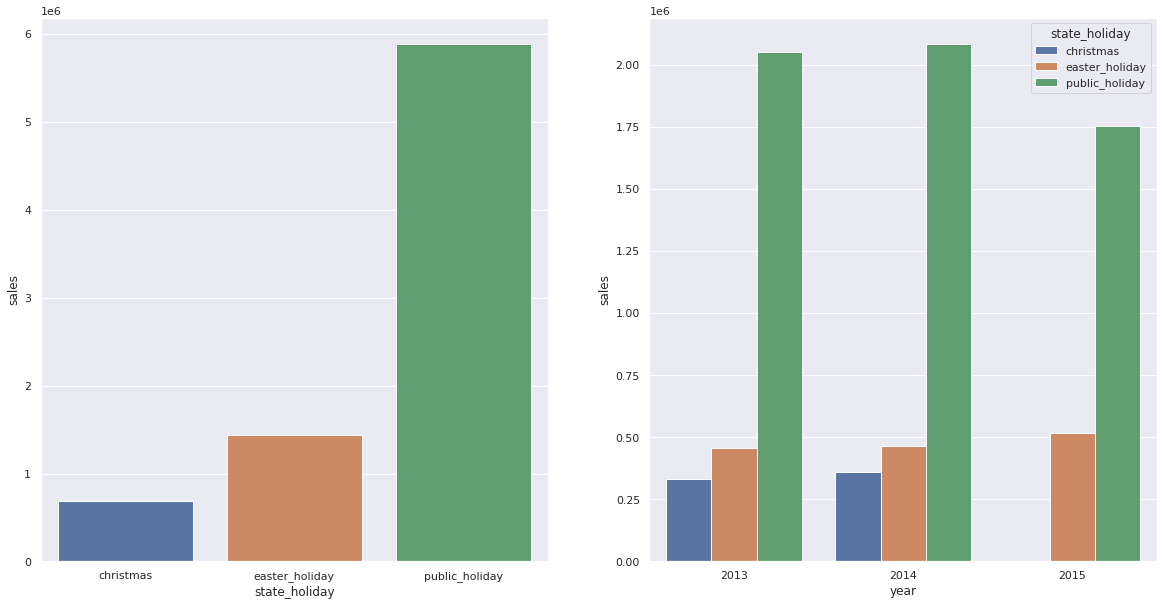

In [192]:
plt.figure( figsize=(20, 10))
aux= df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1,2,1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data = aux1);

plt.subplot(1,2,2)
aux2= aux[['year', 'state_holiday','sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2);   

### **H8.** Lojas  deveriam vender mais ao longo dos anos.
**Falsa** As lojas têm vendido menos ao longo dos anos.

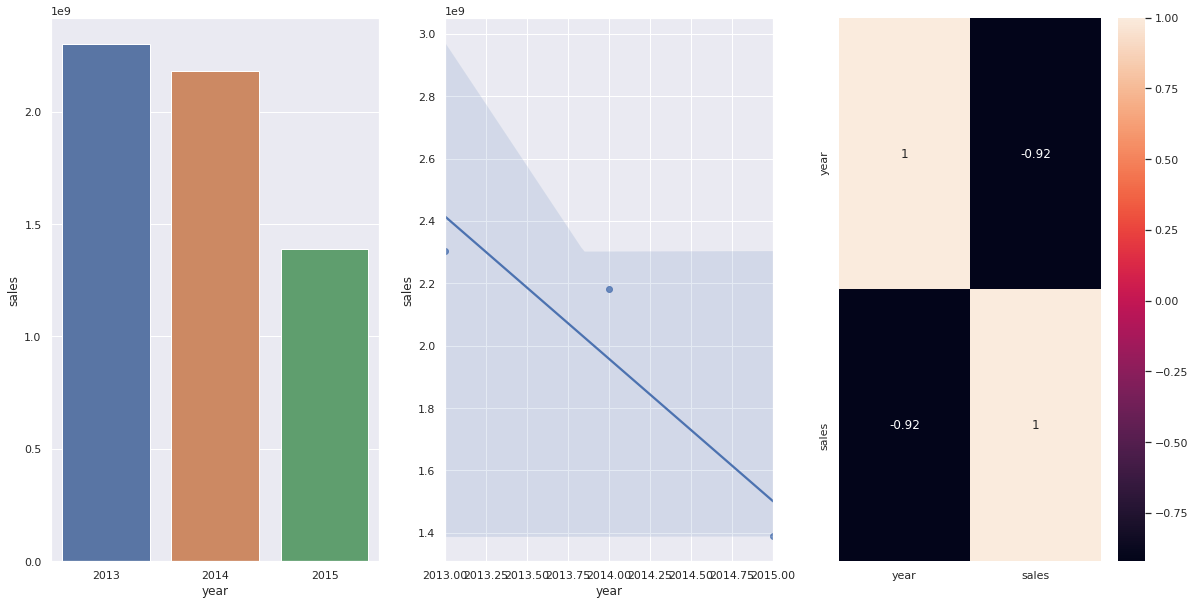

In [193]:
aux1 = df4[['year','sales']].groupby('year').sum().reset_index()
plt.figure( figsize=(20, 10))

plt.subplot(1,3,1)
sns.barplot(x='year', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='year', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);




### **H9.** Lojas  deveriam vender mais no segundo semestre do ano.
**Falsa** As vendas caem no segundo semestre.

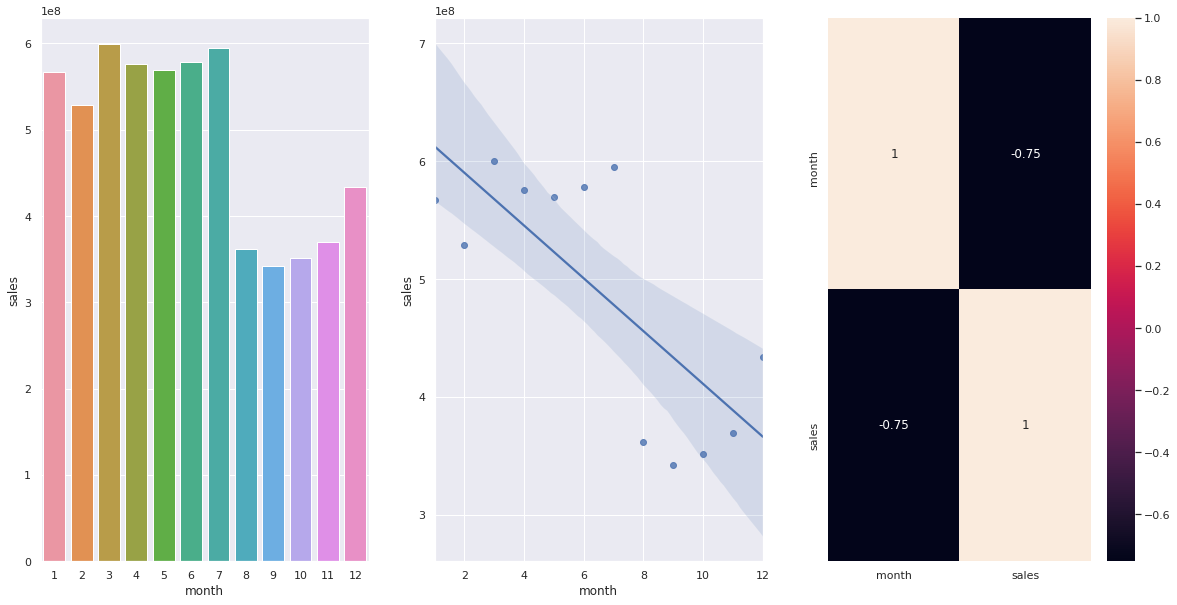

In [194]:
aux1 = df4[['month','sales']].groupby('month').sum().reset_index()
plt.figure( figsize=(20, 10))

plt.subplot(1,3,1)
sns.barplot(x='month', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='month', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);




### **H10.** Lojas  deveriam vender mais depois do dia 10 de cada mês.
**Verdadeira** Lojas vendem mais depois dia 10

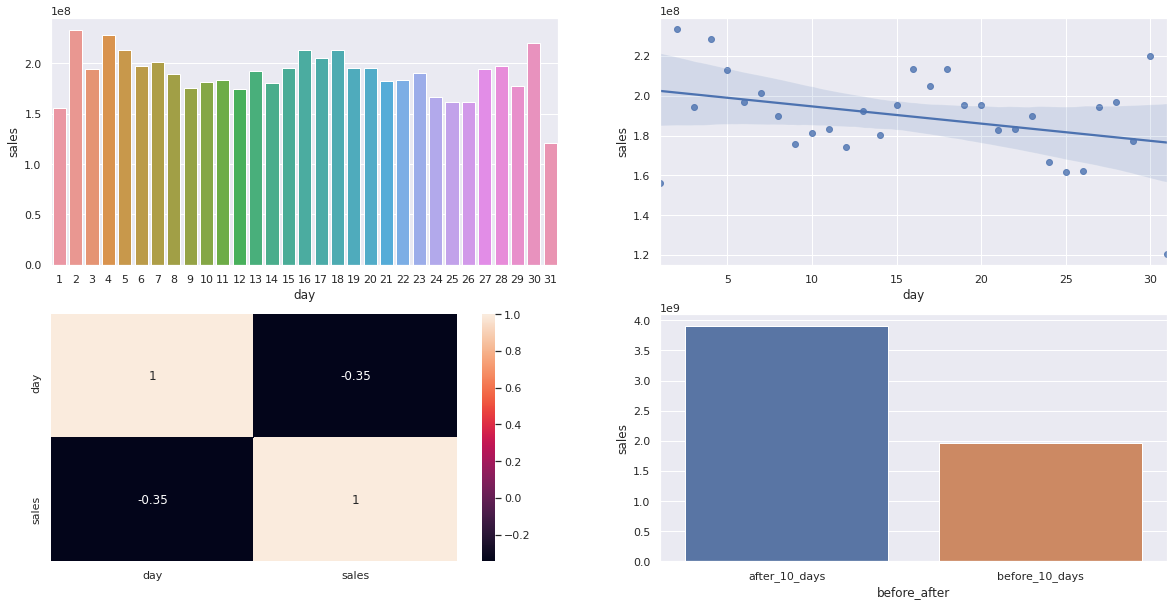

In [195]:
aux1 = df4[['day','sales']].groupby('day').sum().reset_index()
plt.figure( figsize=(20, 10))

plt.subplot(2,2,1)
sns.barplot(x='day', y='sales', data=aux1);

plt.subplot(2,2,2)
sns.regplot(x='day', y='sales', data=aux1);

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x<=10 else 'after_10_days')
aux2= aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

plt.subplot(2,2,4)
sns.barplot(x='before_after', y='sales', data= aux2)

### **H11.** Lojas  deveriam vender menos aos finais de semana.
**Falsa** Lojas vendem menos aos finais de semana.


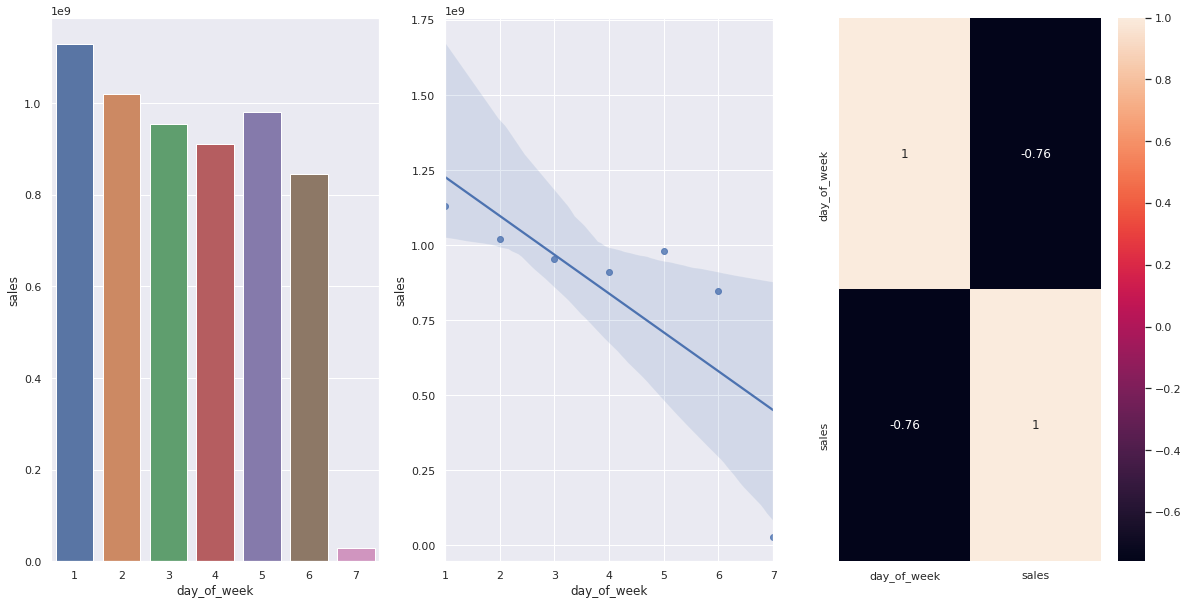

In [196]:
aux1 = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()
plt.figure( figsize=(20, 10))

plt.subplot(1,3,1)
sns.barplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);



### **H12.** Lojas  deveriam vender menos durante os feriados escolares.
**Verdadeira** Lojas vendem menos aos finais de semana, exceto nos meses de julho e agosto.

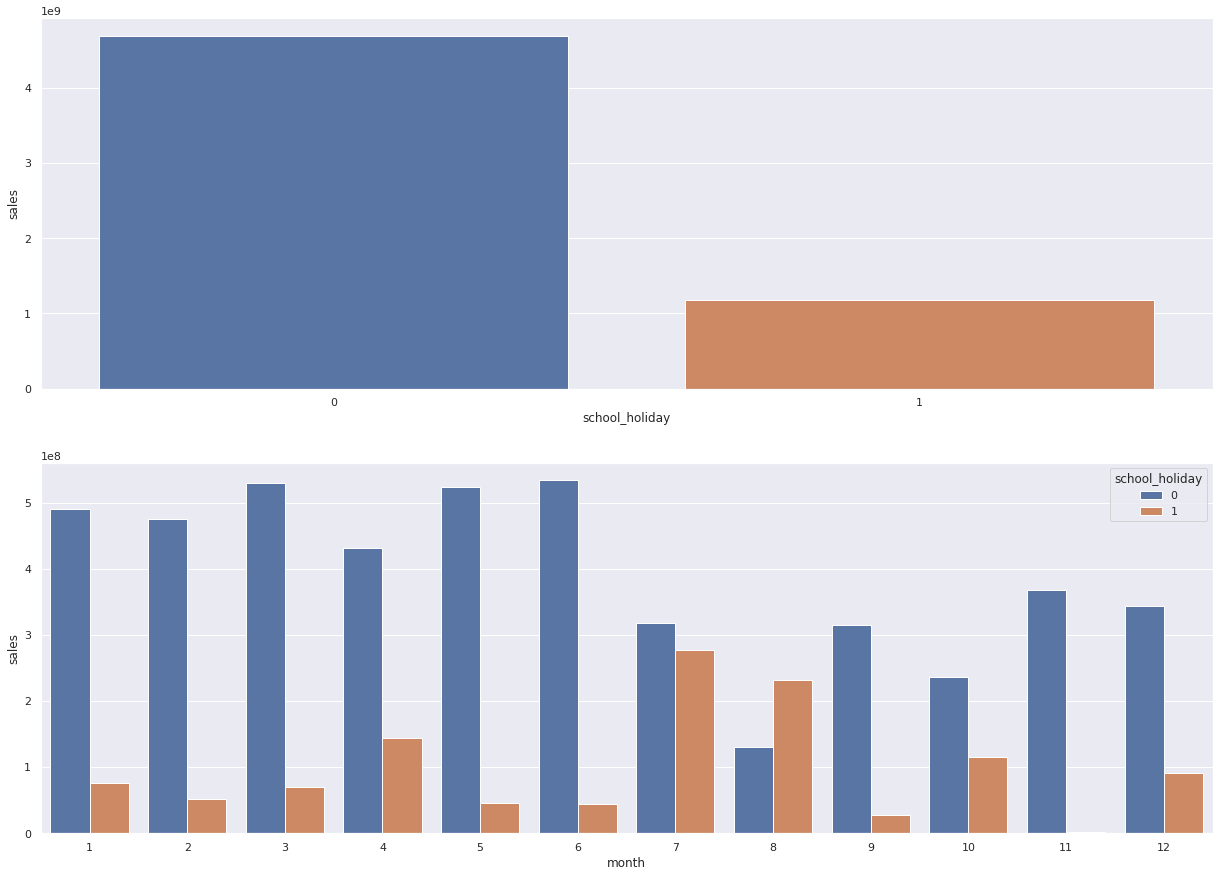

In [197]:
aux1= df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()
plt.subplot(2,1,1)
sns.barplot(x='school_holiday', y='sales', data=aux1);
aux2 =df4[['month','school_holiday','sales']].groupby(['month','school_holiday']).sum().reset_index()
plt.subplot(2,1,2)
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2);



## 4.2.1. Resumo da Hipóteses

In [198]:
tab = [['Hipóteses', 'Conclusão', 'Relevãncia'],
['H1', 'Falsa', 'Baixa'],
['H2', 'Falsa', 'Média'],
['H3', 'Falsa', 'Média'],
['H4', 'Falsa', 'Baixa'],
['H5',   '-',     '-'],
['H6', 'Falsa', 'Baixa'],
['H7', 'Falsa', 'Média'],
['H8', 'Falsa', 'Alta'],
['H9', 'Falsa', 'Alta'],
['H10','Verdadeira', 'Alta'],
['H11','Verdadeira', 'Alta'],
['H12','Verdadeira', 'Baixa'],
]
print(tabulate(tab, headers='firstrow'))

Hipóteses    Conclusão    Relevãncia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Média
H3           Falsa        Média
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Média
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


## 4.3 - Análise Multivariada 

### 4.3.1. Numerical Attributes

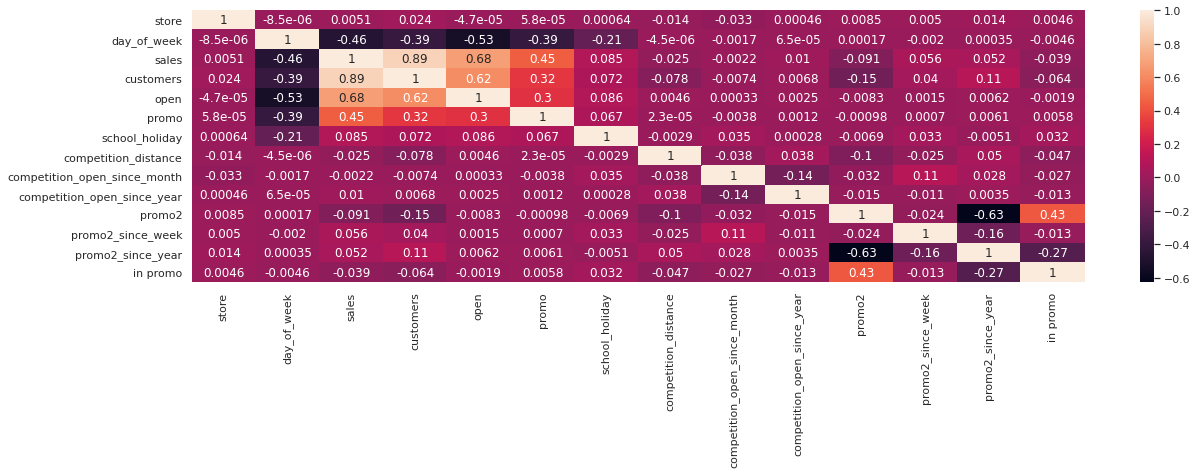

In [199]:
plt.figure( figsize=(20, 5))
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True)

### 4.3.2. Categorical Attibutes

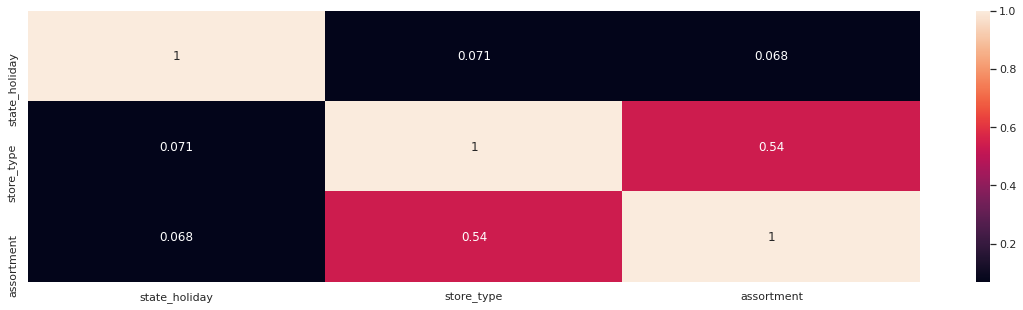

In [200]:
#Only categorical data
a=df4.select_dtypes(include='object')

#Calculante cramer V 
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

#Final dataset
d = pd.DataFrame({'state_holiday':[a1,a2,a3],
              'store_type':[a4,a5,a6],
              'assortment':[a7,a8,a9], })
d = d.set_index(d.columns)
plt.figure( figsize=(20, 5))
sns.heatmap(d, annot=True);      

# 5.0. Data Preparation

In [201]:
df5= df4.copy()

## 5.1. Normalização

### 5.2. Rescaling

In [202]:
a= df5.select_dtypes(include=['int64','float64'])

In [203]:
rs = RobustScaler()
mms = MinMaxScaler()

#competition distance 
df5['competition_distance']= rs.fit_transform(df5[['competition_distance']].values)

#competition time month
df5['competition_time_month']= rs.fit_transform(df5[['competition_time_month']].values)

#year
df5['year']= mms.fit_transform(df5[['year']].values)

#promo time week
df5['promo_time_week']= mms.fit_transform(df5[['promo_time_week']].values)

### 5.3. Transformação





### 5.3.1. Encoding

In [204]:
# state_holiday - One Hot Encoding
df5= pd.get_dummies(df5, prefix =['state_holiday'], columns=['state_holiday'])

# store_type  - Label Enconding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

# assortment - Ordinal Encoding   - Transformou a variavél object em int  
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

In [205]:
df5.head()


,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,in promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015 - 30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1
1,2,5,2015-07-31,6064,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015 - 30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1
2,3,5,2015-07-31,8314,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015 - 30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1
3,4,5,2015-07-31,13995,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015 - 30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1
4,5,5,2015-07-31,4822,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015 - 30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1


### 5.3.2. Response Variable Transformation

In [206]:
df5['sales'] = np.log1p(df5['sales'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


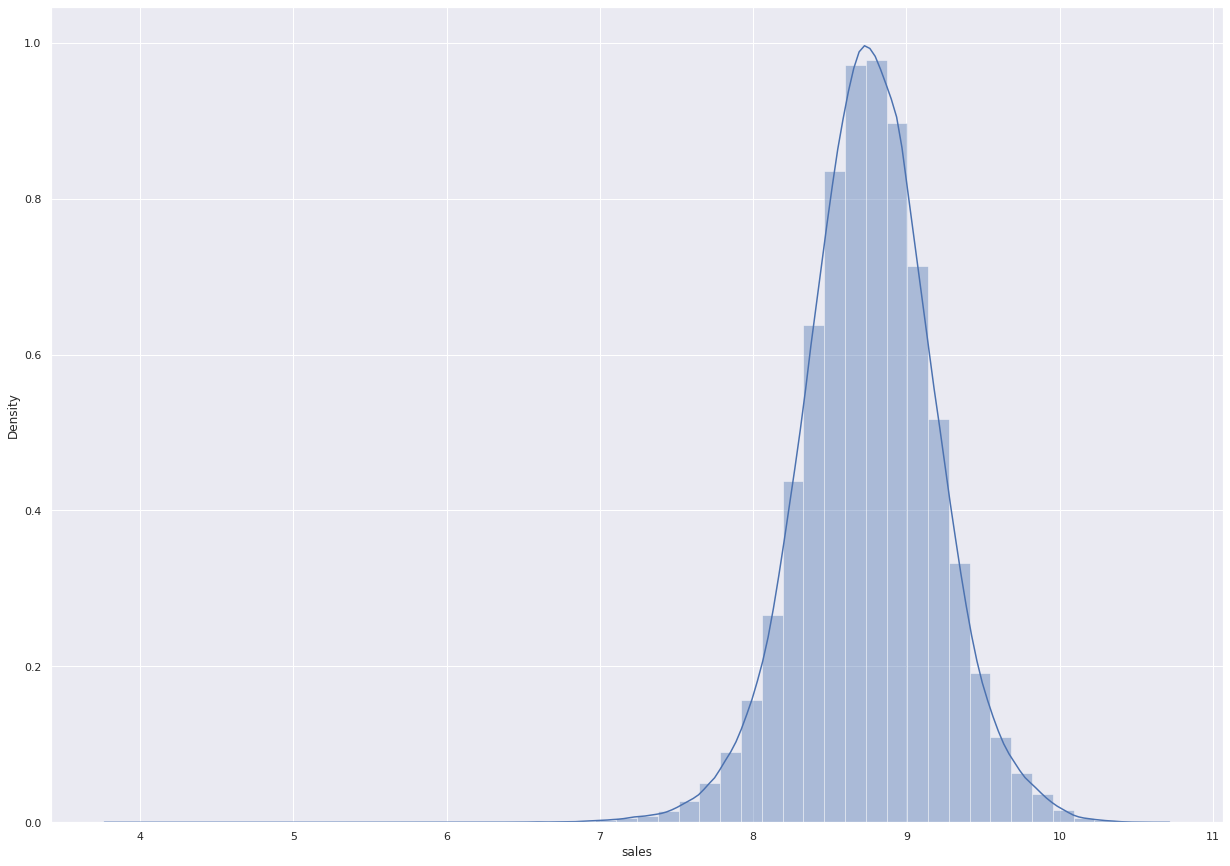

In [207]:
sns.distplot(df5['sales']);

### 5.3.3. Nature Transformation





In [208]:
#day_of_week
df5['day_of_week_sin']= df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7) ) )
df5['day_of_week_cos']= df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7) ) )

#month
df5['month_sin']= df5['month'].apply(lambda x: np.sin(x * (2. * np.pi/12) ) )
df5['month_cos']= df5['month'].apply(lambda x: np.cos(x * (2. * np.pi/12) ) )

#week_of_year
df5['week_of_year_sin']= df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52) ) )
df5['week_of_year_cos']= df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52) ) )

#day
df5['day_sin']= df5['day'].apply(lambda x: np.sin(x * (2. * np.pi/30) ) )
df5['day_cos']= df5['day'].apply(lambda x: np.cos(x * (2. * np.pi/30) ) )



In [209]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,in promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,week_of_year_sin,week_of_year_cos,day_sin,day_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015 - 30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,-0.568065,-0.822984,0.207912,0.978148
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015 - 30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,-0.568065,-0.822984,0.207912,0.978148
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015 - 30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,-0.568065,-0.822984,0.207912,0.978148
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015 - 30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,-0.568065,-0.822984,0.207912,0.978148
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015 - 30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,-0.568065,-0.822984,0.207912,0.978148


#6.0. Feature Selection

In [210]:
df6=df5.copy()

##6.1. Split dataframe into training and test dataset


In [211]:
df6.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,in promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,week_of_year_sin,week_of_year_cos,day_sin,day_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015 - 30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,-0.568065,-0.822984,0.207912,0.978148
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015 - 30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,-0.568065,-0.822984,0.207912,0.978148
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015 - 30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,-0.568065,-0.822984,0.207912,0.978148
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015 - 30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,-0.568065,-0.822984,0.207912,0.978148
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015 - 30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,-0.568065,-0.822984,0.207912,0.978148


##6.2. Boruta as Feature Selector

In [212]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis=1)

In [213]:
df6[['store','date']].groupby('store').max().reset_index()['date'] [0] - timedelta(days=6*7)



Timestamp('2015-06-19 00:00:00')

In [214]:
#Training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

#Test dataset
X_test = df6[df6['date']>= '2015-06-19']
y_test = X_test['sales']

print('Training Min Date: {}'.format(X_train['date'].min() ))
print('Training Max Date: {}'.format(X_train['date'].max() ))

print('\nText Min Date: {}'.format(X_test['date'].min() ))
print('Text Max Date: {}'.format(X_test['date'].max() ))


Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Text Min Date: 2015-06-19 00:00:00
Text Max Date: 2015-07-31 00:00:00


In [215]:
#training and test dataset boruta 
X_train_n = X_train.drop(['date', 'sales'], axis=1).values 
y_train_n = y_train.values.ravel()


#define RangdomForestRegressor
#rf = RandomForestRegressor(n_jobs=-1)

#define boruta
#boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit(X_train_n, y_train_n)

In [216]:
cols_selected = boruta.support_.tolist()
#best features
X_train_fs = X_train.drop(['date','sales'], axis=1)
cols_selected_boruta = X_train_fs.iloc[:, cols_selected ].columns.to_list()

#not selected boruta
cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

In [217]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'week_of_year_cos',
 'day_sin',
 'day_cos']

### 6.3. Manual Feature Selection

In [220]:
cols_selected_boruta = [
  'store',
  'promo',
  'store_type',
  'assortment',
  'competition_distance',
  'competition_open_since_month',
  'competition_open_since_year',
  'promo2',
  'promo2_since_week',
  'promo2_since_year',
  'competition_time_month',
  'promo_time_week',
  'day_of_week_sin',
  'day_of_week_cos',
  'month_sin'
  'month_cos',
  'week_of_year_sin',
  'week_of_year_cos',
  'day_sin',
  'day_cos']

  #columns to add
feat_to_add = ['date','sales']

  #final features 
cols_selected_boruta.extend(feat_to_add)


In [222]:
cols_selected_boruta


['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sinmonth_cos',
 'week_of_year_sin',
 'week_of_year_cos',
 'day_sin',
 'day_cos',
 'date',
 'sales']